# TMA4130/35 Homework assignment 7

This homework assignment is concerned with the implementation of
explicit Runge-Kutta with adaptive time-step control and their application
to a challenge application problem known as the (restricted) three-body problem.

Naturally, you will be given two problem set, where the first focuses on 
the implementation of embedded Runge-Kutta methods while the second centers 
around the application of your shiny new implementation to the three-body problem
and an assessment of the advantages of automatic error estimation 
and time-step selection compared with uniform time-step sizes.

You will find much of necessary background and code in the `RungeKuttaNuMeODE.ipynb`
and `AdaptiveNuMeODE.ipynb` notebooks.

$\newcommand{mb}[1]{\mathbf{#1}}$

As always, we start by calling the necessary modules: And of course we want to import the required modules.

In [1]:
%matplotlib inline

import numpy as np
from numpy import pi
from numpy.linalg import solve, norm    
import matplotlib.pyplot as plt

import pandas as pd

# Use a funny plotting style
plt.xkcd()

newparams = {'figure.figsize': (6.0, 6.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

## Problem 1: Embedded Runge-Kutta methods

In this problem you are asked to implement an `EmbeddedExplicitRungeKutta` class
which extends  the `ExplicitRungeKutta` class from the `RungeKuttaNuMeODE.ipynb`
to include adaptive time-stepping. We start with a short review.

### Review: Runge-Kutta method with stepsize control

A Runge - Kutta methods with an error estimate are usually called **embedded Runge - Kutta methods** or **Runge - Kutta pairs**, and
the coefficients can be written in a Butcher tableau as follows

$$
\begin{array}{c|ccccl}
    c_1 & a_{11} & a_{12} & \cdots & a_{1s} \\ 
    c_2 & a_{21} & a_{22} & \cdots & a_{2s} \\ 
    \vdots & \vdots &&&\vdots \\ 
    c_s & a_{s1} & a_{s2} & \cdots & a_{ss} \\ \hline
        & b_1 & b_2 & \cdots & b_s  & \qquad\text{Order $p$}\\ \hline
        & \widehat{b}_1 & \widehat{b_2} & \cdots & \widehat{b}_s  & \qquad\text{Order $\widehat{p}= p+1$}
   \end{array}.
$$

Now for each time-step, the following **autmatic error estimation and time-step control mechanis** needs to be added:


Given $t_n, \mb{y}_n$ and a step size $\tau_n$. 
* Do one step with the low order method (order $p$) and one step with a high order method (order $\widehat{p}$):
 \begin{align*}
  \mathbf{y}_{n+1} &= \mathbf{y}_n + \tau \mathbf{\Phi}(t_n, \mathbf{y}_n; \tau), && \text{order $p$}, \\ 
  \widehat{\mathbf{y}}_{n+1} &= \mathbf{y}_n + \tau \widehat{\mathbf{\Phi}}(t_n, \mathbf{y}_n; \tau), && \text{order $\widehat{p} = p+1$ or more}. \\ 
\end{align*}

* Then the error is simply estimated  by 
$$ \mb{le}_{n+1} = \tau_n\sum_{i=1}^s (\widehat{b}_i - b_i)\mb{k}_i,
$$ 
and a new time-step suggestion $\tau_{new}$ is computed by
$$
\tau_{new} \approx  \mathrm{fac} \left( \frac{\text{Tol}}{\|\mb{le}_{n+1}\|} \right)^{\frac{1}{p+1}} \tau _{n}.
$$
where $\mathrm{fac} \approx 0.8$ is a safety factor,


* if  $\|\mb{le}\|_{n+1} < \text{Tol}$

    * Accept the solution $t_{n+1}, \mb{y}_{n+1},\widehat{\mb{y}}_{n+1}$ as accurate enough and and set $\mb{y}_{n+1} := \widehat{\mb{y}}_{n+1}$, i.e., use the better approximation to advance to $t_{n+1}$.

    * If possible, use increased step size $\tau_{n+1} := \tau_{new}$ for the next step.

* else

    * Repeat the step from $(t_n,\mb{y}_n)$ with a reduced step size $\tau_n := \tau_{new}$.

__Task a)__  Extend the Runge-Kutta class to include the autmatic error estimation and time-step control mechanism describe above by complementing the following code outline.
Code sections which you need to complet are marked with a `# TODO ` comments, e.g.
```Python
# TODO: Extend previous __call__ routine to take in tolerance tol as well:
    def __call__(self, y0, t0, T, f, Nmax):

```

Don't forget to take into account the points mention in the *Implementation* section in the `AdaptiveNuMeODE.ipynb` notebook to avoid infinite loops, to terminate the solution exactly in $T$ etc.

**Hints:** You want to review how we implemented the Explicit-Euler-Heun method from scratch in code tutorial II `RungeKuttaCodeTutorialsPart_II.ipynb`. That will give a good idea of how you can complete the code outline below.

In [14]:
import numpy as np
from numpy.linalg import norm, solve
import matplotlib.pyplot as plt

class EmbeddedExplicitRungeKutta:
    def __init__(self, a, b, c, bhat, order):
        self.a = a
        self.b = b
        self.c = c
        self.bhat = bhat
        self.order = order

    def __call__(self, y0, t0, T, f, tol, Nmax):
        
        # TODO: Extract Butcher table and 
        a, b, c, bhat, order = self.a, self.b, self.c, self.bhat, self.order
        
        # Stages
        s = len(b)
        ks = [np.zeros_like(y0, dtype=np.double) for s in range(s)]

        # Start time-stepping
        ys = [y0]
        ts = [t0]

        # TODO: What is a simple choice for the initial time step?
        dt = (T - t0)/Nmax

        # Counting steps to avoid infinite loops
        N = 0
        N_rej = 0
        
        while(ts[-1] < T and N < Nmax):
            t, y = ts[-1], ys[-1]
            N += 1

            # Compute stages derivatives k_j
            for j in range(s):
                t_j = t + c[j]*dt
                dY_j = np.zeros_like(y, dtype=np.double)
                for l in range(j):
                    dY_j += a[j,l]*ks[l]

                ks[j] = f(t_j, y + dt*dY_j)
                
            # Compute next time-step
            dy = np.zeros_like(y, dtype=np.double)
            for j in range(s):
                dy += b[j]*ks[j]
            
            # If bhat was not given then fall back to a standard RKM with uniform step size
            if bhat is None:
                ys.append(y + dt*dy)
                ts.append(t + dt)
            # TODO: In the next lines, compute yhat or dyhat, estimate error, 
            # decide whether to accept step or not, compute new time step etc.
            else:
                # TODO: Compute dyhat
                dyhat = 0
                for i in range(s):
                    dyhat += bhat[i] * ks[i]
                dyhat *= dt
                
                # TODO: Error estimate, use norm() function for this
                err = 0
                for i in range(s):
                    err += (bhat[i] - b[i]) * ks[i]
                err *= dt
                err = norm(err)

                # TODO: Accept time-step
                if err <= tol:
                    ys.append(y + dyhat)
                    ts.append(t + dt)
                else:
                    print(f"Step is rejected at t = {t} with err = {err}")
                    N_rej += 1
  
                # TODO: Compute New step size
                dt = 0.9 * (tol/err)**(1/(order+1)) * dt
        
        print(f"Finishing time-stepping reaching t = {ts[-1]} with final time T = {T}")
        print(f"Used {N} steps out of {Nmax} with {N_rej} being rejected\n")
        
        return (np.array(ts), np.array(ys))

__Task b)__

Test your implementation for the **Explicit Euler-Heun pair** and for the **Fehlberg method**.
For each of Runge-Kutta methods, consider two test problems

* $y'= \lambda y$, $y(t_0) = y_0$ with exact solution $y(t) = y_0 e^{\lambda (t-t_0)}$

* $y' = -2 t y$,  $y(0) = y_0$  with exact solution $y(t) = e^{-t^2}$

Solve these test problems numerically for a number of different $\mathrm{Tol}$ to check whether you get reasonable results, 
e.g. by comparing it to the exact solution or to the corresponding explicit Runge-Kutta methods without time-stepping.


Also, here are some orientation/check points for you from the reference implementation in the solution manual.
In both test problems, we used $N_{\mathrm{max}} = 100$, $\mathrm{Tol} = 10^{-3}$, $t_0 = 0, T = 1$ and $y_0 = 1$.
Then
* the Explicit Euler-Heun pair uses $37$ steps for the first
  test problem with $0$ rejections and $31$ steps for the second test problem with $2$ rejections, while
* the Fehlberg method uses $4$ steps for the first
  test problem with $0$ rejections and $6$ steps for the second test problem with $2$ rejections.

Step is rejected at t = 0.412492235949962 with err = 0.12016287111194687
Step is rejected at t = 0.7413010357651466 with err = 0.11201217947188405
Finishing time-stepping reaching t = 1.0209114336939022 with final time T = 1
Used 6 steps out of 100 with 2 being rejected

Finishing time-stepping reaching t = 2.162721078061439 with final time T = 1
Used 2 steps out of 100 with 0 being rejected

Step is rejected at t = 0.9470587304510376 with err = 1.3637020563995574
Finishing time-stepping reaching t = 1.2088767107926413 with final time T = 1
Used 6 steps out of 100 with 1 being rejected

Step is rejected at t = 0.01 with err = 102804.43174256435
Step is rejected at t = 0.33323573087869235 with err = 1085.521503320985
Step is rejected at t = 0.8971254555971102 with err = 1.0137731234179401
Finishing time-stepping reaching t = 1.7170248250946232 with final time T = 1
Used 7 steps out of 100 with 3 being rejected

Finishing time-stepping reaching t = 1.0188093879816345 with final time T = 

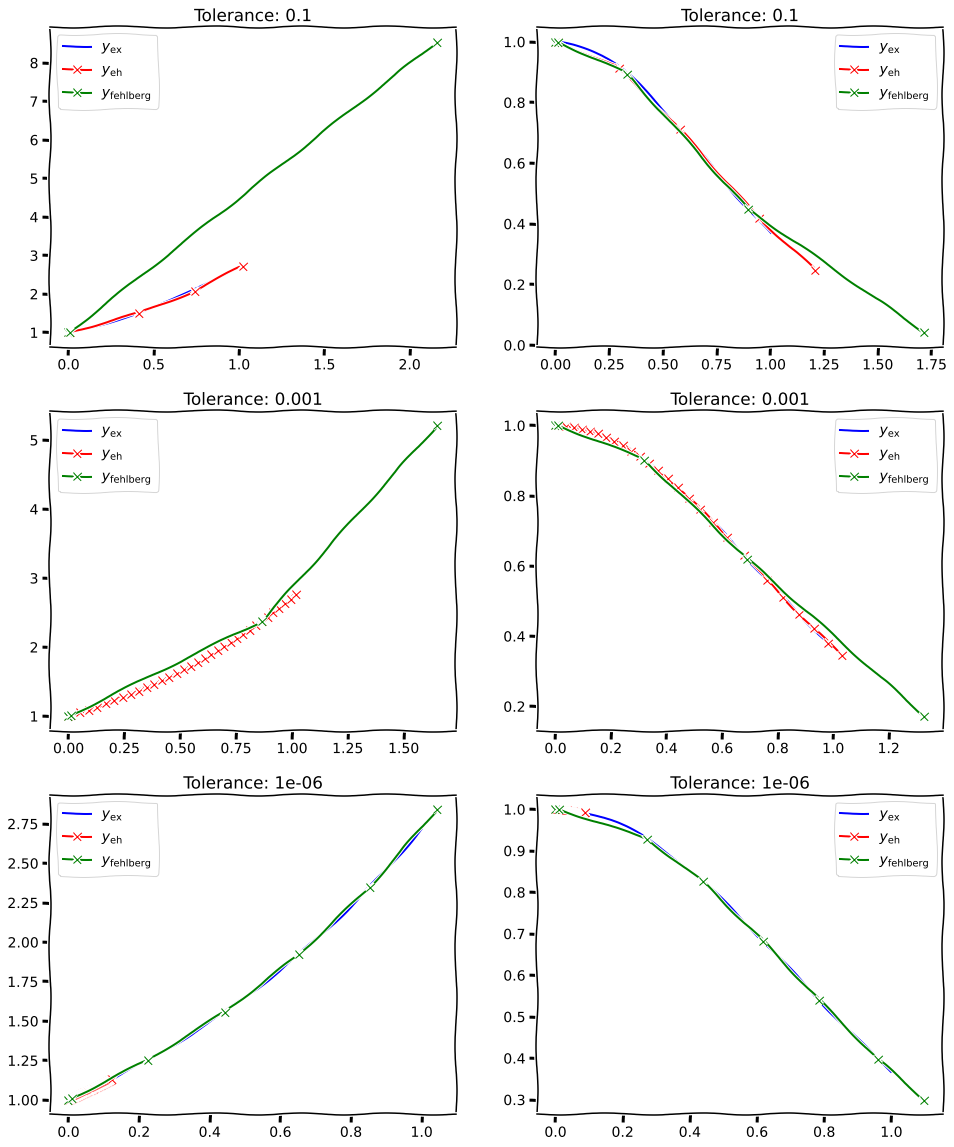

In [23]:
# initial values
y0_1 = 1
y0_2 = 1
t0 = 0
T = 1
tol = np.array([10**(-1), 10**(-3), 10**(-6)])
Nmax = 100
lam = 1

# defining f(y(t))
def f(t, y):
    return lam * y

def g(t, y):
    return -2*t*y

# exact solutions
def y_ex_1(t):
    return y0_1 * np.exp(lam*(t-t0))

def y_ex_2(t):
    return np.exp(-t**2)

# Euler-Heun
a_eh = np.array([[0, 0], [1, 0]])
b_eh = np.array([1, 0])
bhat_eh = np.array([1/2, 1/2])
c_eh = np.array([0, 1])

# Fehlberg
a_f = np.array([[0, 0, 0, 0, 0, 0],
               [1/4, 0, 0, 0, 0, 0],
               [3/32, 9/32, 0, 0, 0, 0],
               [1932/2197, -7200/2197, 7296/2197, 0, 0, 0],
               [439/216, -8, 3680/513, -845/4104, 0, 0],
               [-8/27, 2, -3544/2565, 1859/4104, -11/40, 0]])
b_f = np.array([25/216, 0, 1408/2565, 2197/4104, -1/5, 0])
bhat_f = np.array([16/135, 0, 6656/12825, 28561/56430, -9/50, 2/55])
c_f = np.array([0, 1/4, 3/8, 12/13, 1, 1/2])

# creating the solvers
euler = EmbeddedExplicitRungeKutta(a_eh, b_eh, c_eh, bhat_eh, order=1)
fehlberg = EmbeddedExplicitRungeKutta(a_f, b_f, c_f, bhat_f, order=4)

x = np.linspace(t0, T, Nmax)
ys_ex_1 = np.zeros(Nmax)
ys_ex_2 = np.zeros(Nmax)
for i in range(Nmax):
    ys_ex_1[i] = y_ex_1(x[i])
    ys_ex_2[i] = y_ex_2(x[i])
    
#plotting: left hand is the first IVP, the right hand is the second IVP. Plotting for 3 different tol's
fig, axes = plt.subplots(3,2,figsize=(16,20))
for i in range(3):
    axes[i][0].plot(x, ys_ex_1, 'b-')
    axes[i][1].plot(x, ys_ex_2, 'b-')
    ts, ys = euler(y0_1, t0, T, f, tol[i], Nmax)
    axes[i][0].plot(ts, ys, 'rx-')
    ts, ys = fehlberg(y0_1, t0, T, f, tol[i], Nmax)
    axes[i][0].plot(ts, ys, 'gx-')
    axes[i][0].legend(["$y_{\mathrm{ex}}$", "$y_{\mathrm{eh}}$", "$y_{\mathrm{fehlberg}}$"])
    ts, ys = euler(y0_2, t0, T, g, tol[i], Nmax)
    axes[i][1].plot(ts, ys, 'rx-')
    ts, ys = fehlberg(y0_2, t0, T, g, tol[i], Nmax)
    axes[i][1].plot(ts, ys, 'gx-')
    axes[i][1].legend(["$y_{\mathrm{ex}}$", "$y_{\mathrm{eh}}$", "$y_{\mathrm{fehlberg}}$"])
    axes[i][0].set_title(f"Tolerance: {tol[i]}")
    axes[i][1].set_title(f"Tolerance: {tol[i]}")

## Problem 2: Numerical solution of the restricted three body problem

### Brief history of the three body problem

One of the first problems to be solved with differential equations was that of the motion of planets. Actually, some people will say that calculus was invented to solve the ODEs for planets. When there are two heavy bodies, e.g., earth and moon, the motion of their mass center $x_E$ and $x_M$ can be modeled by 
\begin{align*}
    m_E \overset{\cdot \cdot}{x}_E(t) =& - G\frac{m_E \cdot m_M}{||x_E-x_M||^3} (x_E - x_M) \\
    m_M \overset{\cdot \cdot}{x}_M(t) =& - m_E \overset{\cdot \cdot}{x_E}(t)
\end{align*}
Where $m_E$ is the mass in kilograms of the Earth (resp. $m_M$ for the Moon) and $x_E$ are some coordinates in the outer space of the Earth (resp. $x_M$ for the Moon). Here $G$ is the [Graviational constant](https://en.wikipedia.org/wiki/Gravitational_constant).

There are plenty of symmetries and tricks which can be used to find exact solutions. Nowadays, Kepler's elliptic orbits or the return of Halley's comet are well known exact solutions of this problem. But what happen when there are three or more objects? For instance, if one wants to model
the motion of satellites or spaceships in the earth-moon system?
Then the resulting ODE system does not as simple as before,
\begin{align}
    \label{eq.Earth}
    m_E \overset{\cdot \cdot}{x}_E(t) =& 
        - G\frac{m_E \cdot m_M}{||x_E-x_M||^3} ( x_E - x_M )
        - G\frac{m_E \cdot m_S}{||x_E-x_S||^3} ( x_E - x_S ) \\
    \label{eq.Moon}
    m_M \overset{\cdot \cdot}{x}_M(t) =& 
        - G\frac{m_M \cdot m_E}{||x_M-x_E||^3} ( x_M - x_E )
        - G\frac{m_M \cdot m_S}{||x_M-x_S||^3} ( x_M - x_S ) \\
    m_S \overset{\cdot \cdot}{x}_S(t) =& 
        - G\frac{m_S \cdot m_E}{||x_S-x_E||^3} ( x_S - x_E )
        - G\frac{m_S \cdot m_M}{||x_S-x_M||^3} ( x_S - x_M )
\end{align}
This do not look so simple anymore and exact solutions cannot be produced anymore through symmetry considerations. This is of course worrysome since space agencies and the telecomunication industries want to send devices and people into space, and it is thus of utmost importance 
to predict the trajectories of small-scale artifiical space objects with high accuracy.
To this end, we want to make sure that communication satellites are put into stable orbits
and that manned space rockets will return to earth and not get lost in the space.

In the 1960s, people like [Richard Arenstorf](https://www.johndcook.com/blog/2020/02/08/arenstorf-orbit/) worked out this problem with a simple observation. Earth and Moon masses are around $5.972 \cdot10^{24} \mathrm{kg}$ and $7.348 \cdot 10^{22}\mathrm{kg}$, while artificial satellites are much lighter in comparison, e.g. for the Apollo missions it was around $10^5 \mathrm{kg}.$ That means that a satellite is $10^{-17}$ as heavy as the moon.
In other words, we can probably neglect the gravitational effects of human created space objects on the moon and earth (but not the other way around!). This leads to the so-called **restricted three body problem**,
for which the following two periodic orbits were found by Arenstorf.

<img src="https://wiki.math.ntnu.no/_media/tma4130/2021h/ArenstorfOrbit1.png" width=256 height=256 /> <img src="https://wiki.math.ntnu.no/_media/tma4130/2021h/ArenstorfOrbit2.png" width=256 height=256 />

An important quantity in this problem is the relative mass of the moon
$$
\mu :=  \frac{m_M}{m_E + m_M}
$$
The high mass ratio between moon and satellite is thus also relevant from a computational point of view.
In the first week of this course when the representation of numbers on computers were discussed, we learned 
that the relative accuracy is determined by the number of significant digits in the floating point representation. For the standard `double type` numbers available in $\texttt{C++}$ or $\texttt{Python}$, we have usually 16 digits at our disposal.
Thus, numerical-wise taking the mass of the satellite $m_S$ into account when computing the relative moon mass does not make sense/is difficult since $m_E + m_M = m_E + m_M + m_S$ when these numbers are representated on a computer using standard float number representations.


### The restricted three-body problem

We only sketch main ideas for how to derive the ODE system for the restricted three-body problem,
for a detailed derivation, we refer to [these lecture notes](https://www.phys.uconn.edu/~rozman/Courses/P2200_13F/downloads/restricted-three-body.pdf).

First, the unit for the lenght scale is changed so that the distance between Earth and Moon is $1$. 
Then the reference frame is changed so the $0$ corresponds to the center of gravity $x_E m_E + x_M m_M$ for the Earth-Moon system
lies at the origin of the coordinate system. (Remember that the mass of the satellite can be neglected.).
Also, the coordinate system is suppose to move along with the relative earth-moon position, such that the first coordinate axis
is along the earth-moon axis.
Also, due to symmetry considerations mentioned above, it is simpler to work with the relative mass of the moon defined
\begin{align*}
    \mu :=   \frac{m_M}{m_E + m_M}  \approx 0.012277471.
\end{align*}
Note that $1-\mu$ is then the relative mass of the earth. 
 

To this end, the satellite will move a $\xi-\eta$ plane with the earth and moon positions fixed at $(-\mu, 0)$ and $(1-\mu, 0)$, respectively.
The coordinates $(\xi(t),\eta(t))$ of the moving satellite will then satisfies the ODE system

\begin{align*}
    \frac{d^2}{dt^2} \xi =& -2\frac{d\eta}{dt} + \frac{\partial}{\partial \xi} V \\
    \frac{d^2}{dt^2} \eta =& 2\frac{d\xi}{dt} + \frac{\partial}{\partial \eta} V,
\end{align*}
where $V, d_1, d_2$ are given by 
\begin{align*}
   V(\xi,\eta) =& \frac{\eta^2+\xi^2}{2} + \frac{1-\mu}{d_1} + \frac{\mu}{d_2}
   \\
   d_1 &=\sqrt{ (\eta+\mu)^2 + \xi^2 }
   \\
   d_2 &=\sqrt{ (\eta-1+\mu)^2 + \xi^2 }
\end{align*}.

**Task a)**
Find the explicit expressions of $\eta^{\prime\prime}(t)$ and $\xi^{\prime\prime}(t)$ by explicitly calculating the
derivatives $\dfrac{\partial}{\partial\eta}V$ and $\dfrac{\partial}{\partial\xi}V$.

Then rewrite the system of second-order differential equations for $(\xi,\eta)$ as a system of first order ODEs.
Verify that the number of initial conditions one need is 4.

**Hint:** You might want to take a look at the end of the `IntroductionNuMeODE.ipynb` notebook, where we explained in general how
to transform a $m$-order ODE into a first-order system. There is also an example transforming the 2nd order van der Pols equation into a first-order system. 

**Task b)** Next define a `Python` function `f(t,y)` which implementents the right-hand side function for the first-order system you just derived.
You can start from the following code snippet.

In [ ]:
# Parameters for the system 
mu = 0.012277471
earth = np.array( [-mu , 0 ])
moon = np.array([ 1-mu , 0] )

# Force field to be solved
def f(t,y):
    
    # y = (xi,eta,xi_prime,eta_prime)
    xi, eta, xi_prime, eta_prime = y 

    # the distances can be computed using linalg in numpy
    d1 = np.linalg.norm( y[0:2] - earth , 2 )
    # TODO
    d2 = ...
    
    # the vector of derivatives
    dy1 = xi_prime        
    dy2 = eta_prime 
    
    # TODO
    dy3 =  ... # fill in here the second derivative of eta
    dy4 =  ... # fill in here the second derivative of xi

    return np.array([dy1,dy2,dy3,dy4])

**Task c)** Solve the ODE for $(\xi(t),\eta(t))$ for $t\in [0,20]$ for *3 different sets of initial conditions*.

In all three of them, we set
\begin{align*}
    \xi(0) &= 0.994 \\ 
    \eta(0) &= 0 \\
    \xi^\prime(0) &= 0 
\end{align*}

In the first set $\eta^\prime(0)=-2.0317326$, in the second set $\eta^\prime(0)=-2.0015851$. These two conditions will generate the **periodic Arenstorf orbits** pictured above. 
In the third set $\eta^\prime(0)=-2.1$, and this will help to show that this problem is very sensitive to small changes in initial conditions.

Use a the **classical Runge-Kutta method with $4$ stages** without time-step adaption, that is with a uniform step-size $\tau  = \dfrac{T-t_0}{N_{\mathrm{max}}}$  for some given maximal number of steps $N_{\mathrm{max}}$.
Start from $N_{\mathrm{max}} = 1000$ and try to find out, how large you have to choose $N_{\mathrm{max}}$ to reproduce
the two Arenstorf orbits shown above.

**Task d)** Now rerun the experiment from **c)**, but this time the
the  **time-step adaptive Fehlberg method** you implemented and tested in **Problem 1** with $N_{max}=1000$ and a tolerance of $10^{-6}$. 

For all three sets of initial conditions, record/find 
* the number of steps to reach the final time $T$
* the number of rejected steps
* the smallest time-step $\tau_{\mathrm{min}}$ and the largest time-step $\tau_{\mathrm{max}}$ used during the computation and caculate their ratio.

Compare the work efficiency of the adaptive Fehlberg with the classical 4 stage Runge-Kutta methods. Which one would you prepare and why?

**Hint:** To find the smallest and larges time-step, you can either record during the numerical computation or you
can find them after the numerical computation by looking at the list of time-steps `ts` and use the 
[np.diff](https://numpy.org/doc/stable/reference/generated/numpy.diff.html) function.